This notebook uses a vanilla (basic) Bayesian optimization algorithm to tackle an urban travel demand (i.e., origin-destination, OD) calibration problem. The traffic simulations are based on the SUMO simulator.


# SUMO configuration


**Mount GDrive**

If you are working w/ colab rather than a jupyterlab notebook this drive mounting and sumo installation will need to be done every time you restart the runtime.


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

**Setup venv**

In [2]:
# %python -m venv .venv
# %source .venv/bin/activate

**Install SUMO**


In [3]:
# %sudo add-apt-repository -y ppa:sumo/stable
# %sudo apt-get update
# %sudo apt-get -y install sumo sumo-tools sumo-doc &

Set sumo env vars


In [4]:
# Set environment variable
import os
import sys
os.environ['SUMO_HOME'] = 'C:/Program Files (x86)/Eclipse/Sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci


# Macros / utils


In [5]:
base_path = 'C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark'

# if base_path has a space in it, the sumo code will not work
if ' ' in base_path:
    raise ValueError("base_path should not contain spaces")

os.chdir(base_path)

In [6]:
# install missing packages
# %pip install -r requirements.txt

In [7]:
import os
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood


from bayesian_optimization.helpers_sh import (load_kwargs_config,  ### <- helpers를 helpers_sh로 변경 (load_kwargs_config 함수의 마지막 input parameter를 제거하고 "sim_setup.json"을 추가함)
                    compute_nrmse_counts_all_edges, 
                    parse_loop_data_xml_to_pandas, 
                    create_taz_xml,
                    simulate_od,
                    od_xml_to_df,
                    )

In [8]:
config = load_kwargs_config(base_path, "bo_vanilla", "sim_setup_network1_SF_selectedEdges.json")  ### <- 에서 , "sim_setup.json"를 제거함
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

{'BATCH_SIZE': 1,
 'CPU_COUNTS': 8,
 'EDGE_OUT_STR': 'edge_data.xml',
 'NITER': 100,
 'NUM_RESTARTS': 10,
 'RAW_SAMPLES': 32,
 'SAMPLE_SHAPE': 128,
 'SUMO_PATH': 'C:/Program Files (x86)/Eclipse/Sumo',
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': WindowsPath('C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/network/network1_SF_selectedEdges/additional.xml'),
 'edge_selection': WindowsPath('C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/network/network1_SF_selectedEdges/edge_selection.txt'),
 'file_gt_od': WindowsPath('C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/network/network1_SF_selectedEdges/od.xml'),
 'fixed_routes': WindowsPath('C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/network/network1_SF_selectedEdges/routes.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 30,
 'net_xml': WindowsPath('C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/network/network1_SF_selectedEdges/net.xml'),
 'network_name': 'network1_SF_selectedEdg

# Create GT (ground truth) scenario


In [9]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)

# if config["edge_selection"] exists
if "edge_selection" in config:
    if not os.path.exists(config["edge_selection"]):
        edge_selection = None
    else:
        print(f"Reading: {config['edge_selection']}")
        edge_selection = pd.read_csv(config["edge_selection"], header=None)
        edge_selection.columns = ["edge_id"]
        edge_selection = edge_selection["edge_id"].tolist()
else:
    edge_selection = None


Reading: C:\Users\seung\Documents\GIT\BO_UrbanMobility_Benchmark\network\network1_SF_selectedEdges\od.xml
total GT demand:  6000.0
Reading: C:\Users\seung\Documents\GIT\BO_UrbanMobility_Benchmark\network\network1_SF_selectedEdges\routes.csv
Reading: C:\Users\seung\Documents\GIT\BO_UrbanMobility_Benchmark\network\network1_SF_selectedEdges\edge_selection.txt


Simulate the GT scenario to obtain the GT traffic statistics


In [10]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)
print(base_od)

# Run simulation
simulate_od(new_od_xml, 
            prefix_output_gt, 
            base_path, 
            config["net_xml"], 
            config["taz2edge_xml"], 
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])

Created  C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/output/network1_SF_selectedEdges_bo_vanilla/ground_truth/od.xml
       from        to   count  data
0  T1_680_1  T1_880_1  1000.0  None
1  T1_680_1  T1_101_2  2000.0  None
2  T1_680_1  T1_280_1   500.0  None
3  T1_680_1   T1_17_1  1500.0  None
4  T1_680_1  T1_101_1  1000.0  None
od2trips  --spread.uniform --taz-files C:\Users\seung\Documents\GIT\BO_UrbanMobility_Benchmark\network\network1_SF_selectedEdges\taz.xml --tazrelation-files output/network1_SF_selectedEdges_bo_vanilla/ground_truth/od.xml -o C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/output/network1_SF_selectedEdges_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
###### Running SUMO #######
Seed 0
sumo --output-prefix output/network1_SF_selectedEdges_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=C:\Users\seung\Documents\GIT\BO_UrbanMobility_Benchmark\network\network1_SF_selectedEdges\net.xml --routes=C:/Users/seung/Documents

Read and process the GT simulation outputs


In [11]:
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt, config["SUMO_PATH"], edge_list=edge_selection)
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

print(sim_edge_out_gt)
print(gt_edge_data)  # .head()

Filtering edges to [['edge_id', '394385113', '394385111', '965883393', '28433666#0', '395362577', '966336760', '851544880', '394385114', '119271337', '617235612', '28319616', '60759806', '848489711', '395336990', '23011290#0', '28437207', '963563480', '23807076', '848920992', '28319427', '699542380#1', '123592887#0', '23807653', '963510226', '851520670', '30637720', '24167679', '963510313', '1011949858', '23820853', '206086131', '963510311', '848501101', '851569274', '395337004', '867290381', '849806971', '955977953', '119271213', '516535357', '956168972', '28433451', '851548985', '617235603', '550284602', '28665770', '184867226', '848875024', '550271868', '395336979', '963455414', '52305981', '867256163', '23807652', '963455403', '849677308', '963455396', '963510345', '854215625', '956168973', '617284138', '394449801', '28665763', '947247192', '848920992', '550284606', '24167679', '28319618#1', '395343260', '963455394', '875161026#0', '850098170', '1011949858', '28435048', '4629955', 

# Optimization

Vanilla Bayesian Optimization (BO)


Bayesian optimization utils / helpers


In [12]:
def initialize_gp_model(train_X,train_Y):
    dim = train_X.size(dim=1)

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )

    gp_model = SingleTaskGP(
        train_X, train_Y,
        covar_module=covar_module, likelihood=likelihood,
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    return gp_model, gp_mll

def optimize_acqf_and_get_observation(acq_func, bounds, device, dtype, BATCH_SIZE, NUM_RESTARTS, RAW_SAMPLES):
    """Optimizes the acquisition function, and returns a new candidate."""

    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values
    new_x = candidates.detach()

    return unnormalize(new_x, bounds)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype) 

cpu
5


## Create and simulate a sample of initial input points (i.e., ODs).


In [14]:
# Sample according to Sobol
sobol = SobolEngine(dim_od, scramble=True)
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device)
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)

In [15]:
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i , x in enumerate(train_X0.tolist()):
      print(f"########### OD: {i} ###########")
      print(x)
      
      simulation_run_path_init =f'{config["simulation_run_path"]}/initial_search'
      Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)
      
      new_od_xml = f"{simulation_run_path_init}/init_od_{config['network_name']}_{i}.xml"
      prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

      # Generate OD
      #curr_od = gt_od_vals.copy()
      curr_od = np.array(x)

      print(f'total expected GT demand: {np.sum(curr_od)}')

      ###
      # create OD xml file 
      ###
      base_od['count'] = curr_od
      # round to 1 decimal point
      base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
      base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
      create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)
      ods_epsilon.append(curr_od)

      # simulate initial search
      simulate_od(new_od_xml,
                  prefix_output_init,
                  base_path,
                  config["net_xml"], 
                  config["taz2edge_xml"], 
                  config["additional_xml"],
                  routes_df,
                  config["sim_end_time"],
                  config["TRIPS2ODS_OUT_STR"])

      ## Compute loss
      #prefix_output = f'initial_search/sobol_{i}'
      sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
      print(sim_edge_out)
      curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_init,config["SUMO_PATH"], edge_list=edge_selection)
      curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

      loss_all.append(curr_loss)
      print(f"############## loss: {curr_loss} ##############")

      # Parse training data
      df_curr = pd.DataFrame(curr_od.reshape(1,dim_od),
                        columns = [f"x_{i+1}" for i in range(dim_od)])
      df_curr['loss'] = curr_loss
      batch_data_i.append(df_curr)

df_initial_bo = pd.concat(batch_data_i)
# Save initial dataset
df_initial_bo.to_csv(f"{simulation_run_path_init}/data_set_ods_0_2000.csv",index=None)
print(f"save df_initial_bo at {simulation_run_path_init}/data_set_ods_0_2000.csv")


########### OD: 0 ###########
[1884.222149848938, 265.7783031463623, 1044.3607568740845, 285.45936942100525, 270.58351039886475]
total expected GT demand: 3750.4040896892548
Created  C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/output/network1_SF_selectedEdges_bo_vanilla/initial_search/init_od_network1_SF_selectedEdges_0.xml
od2trips  --spread.uniform --taz-files C:\Users\seung\Documents\GIT\BO_UrbanMobility_Benchmark\network\network1_SF_selectedEdges\taz.xml --tazrelation-files output/network1_SF_selectedEdges_bo_vanilla/initial_search/init_od_network1_SF_selectedEdges_0.xml -o C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/output/network1_SF_selectedEdges_bo_vanilla/initial_search/sobol_0_trips_beforeRteUpdates.xml
###### Running SUMO #######
Seed 0
sumo --output-prefix output/network1_SF_selectedEdges_bo_vanilla/initial_search/sobol_0_ --ignore-route-errors=true --net-file=C:\Users\seung\Documents\GIT\BO_UrbanMobility_Benchmark\network\network1_SF_selectedEdges\n

## Run BO epochs


In [16]:
sampler = StochasticSampler(sample_shape=torch.Size([config["SAMPLE_SHAPE"]]))
df_0 = pd.read_csv(f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv")

### Run loop
best_value = []

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

df_edge_stats = pd.DataFrame()

#num_epsilon_iter = 2
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

# TODO for loop for multiple restarts
for i in range(config["NITER"]):
    # new_od_xml = f'{config["simulation_run_path"]}/od.xml'
    #   new_od_xml = f"{simulation_run_path_init}/init_od_{config['network_name']}_{i}.xml"
    #   prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

    simulation_run_path_BO =f'{config["simulation_run_path"]}/BO'
    Path(simulation_run_path_BO).mkdir(parents=True, exist_ok=True)

    ########
    # Start BO step
    ########

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    ).to(device=device, dtype=dtype)

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    print(f"Generating new sampling location(s)....")
    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function
    # sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qLogExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)

    # Maximize acquisition function to get next observation
    x_i = optimize_acqf_and_get_observation(acq_func=qEI,
                                            bounds=bounds,
                                            device=device,
                                            dtype=dtype,
                                            BATCH_SIZE=config["BATCH_SIZE"],
                                            NUM_RESTARTS=config["NUM_RESTARTS"],
                                            RAW_SAMPLES=config["RAW_SAMPLES"])
    
    # if sum(x_i) == 0: skip remainder of loop
    if x_i.sum() == 0:
        print("All zeros, skipping loop")
        continue

    # map the normalized into the original parameter space
    #x_i = unnormalize(x_i, bounds)
    x_i = x_i.cpu().detach().numpy()

    ########
    # End BO step
    ########


    # Sample simulator (inner loop across all sampling locations within a batch)
    batch_data_i = []
    for j in range(config["BATCH_SIZE"]):
        loss_all = []
        print(f"########### Sampling location={j+1} ###########")

        new_od_xml_bo = f"{simulation_run_path_BO}/bayesOpt_od_{config['network_name']}_{i}_{j}.xml"
        prefix_output_bo = f'{simulation_run_path_BO}/bayesOpt_{i}_{j}'

        # Generate OD
        #curr_od = gt_od_vals.copy()
        curr_od = x_i[j]

        print(f'total expected GT demand: {np.sum(curr_od)}')

        base_od['count'] = curr_od
        # round to 1 decimal point
        base_od['count'] = [round(elem, 1) for elem in base_od['count']]
        base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
        create_taz_xml(new_od_xml_bo, base_od, config["od_duration_sec"], base_path)

        # simulate gt od
        simulate_od(new_od_xml_bo,
                    prefix_output_bo,
                    base_path,
                    config["net_xml"],
                    config["taz2edge_xml"],
                    config["additional_xml"],
                    routes_df,
                    config["sim_end_time"],
                    config["TRIPS2ODS_OUT_STR"])

        ## Compute loss
        sim_edge_out = f'{base_path}/{prefix_output_bo}_{config["EDGE_OUT_STR"]}'
        print(sim_edge_out)
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_bo,config["SUMO_PATH"], edge_list=edge_selection)

        curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
        loss_all.append(curr_loss)
        print(f"############## loss: {curr_loss} ##############")

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = curr_loss
        batch_data_i.append(df_j)

        curr_loop_stats['bo_iteration'] = i
        curr_loop_stats['batch'] = j
        df_edge_stats = pd.concat([df_edge_stats, curr_loop_stats])

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
##### best_value=-0.0837529676184226 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 6169.5076904994485
Created  C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/output/network1_SF_selectedEdges_bo_vanilla/BO/bayesOpt_od_network1_SF_selectedEdges_0_0.xml
od2trips  --spread.uniform --taz-files C:\Users\seung\Documents\GIT\BO_UrbanMobility_Benchmark\network\network1_SF_selectedEdges\taz.xml --tazrelation-files output/network1_SF_selectedEdges_bo_vanilla/BO/bayesOpt_od_network1_SF_selectedEdges_0_0.xml -o C:/Users/seung/Documents/GIT/BO_UrbanMobility_Benchmark/output/network1_SF_selectedEdges_bo_vanilla/BO/bayesOpt_0_0_trips_beforeRteUpdates.xml
###### Running SUMO #######
Seed 0
sumo --output-prefix output/network1_SF_selectedEdges_bo_vanilla/BO/bayesOpt_0_0_ --ignore-route-errors=true --net-file=C:\Users\seung\Documents\GIT\BO_UrbanMobility_Benchmark\network\network1_SF_sele

Store outputs


In [17]:
print(f"saving at {config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_training.to_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv",index=None)

print(f"saving at {config['simulation_run_path']}/BO/df_edge_stats.csv")
df_edge_stats.to_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv",index=None)

saving at output/network1_SF_selectedEdges_bo_vanilla/BO/data_set_bayes_opt.csv
saving at output/network1_SF_selectedEdges_bo_vanilla/BO/df_edge_stats.csv


# Results analysis


Read BO outputs


In [18]:
df_training = pd.read_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_edge_stats = pd.read_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv")

Convergence plots


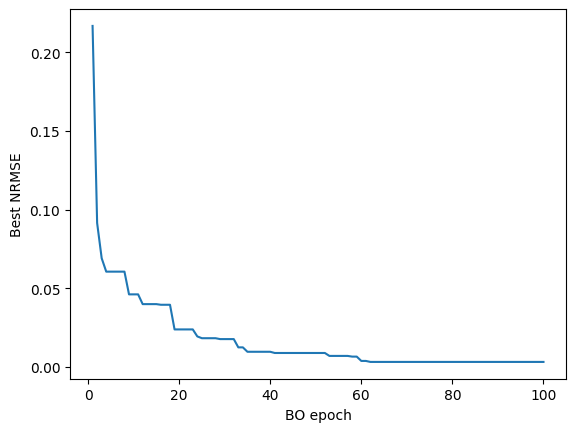

In [19]:
df_plot = df_training.query('bo_iteration>0')
x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x, y)
#plt.legend(title='Parameter where:')
plt.xlabel('BO epoch')
plt.ylabel('Best NRMSE')
# plt.show()
plt.savefig(f"{config['simulation_run_path']}/bo_nrmse.png")


In [20]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)



Scatter plots: fit to traffic data

Bar plots: fit to OD data


In [21]:
# disable interactive mode
plt.ioff()

if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    plt.figure()    
    # plotting diagonal line that represents a perfect data fit
    max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
    vec = np.arange(max_val)
    plt.plot(vec, vec, 'r-')
    plt.plot(df1b.interval_nVehContrib_gt, df1b.interval_nVehContrib_bo, 'x') 
    # plt.title(f'BO epochs: {o1}; loss: {curr_loss}')
    plt.xlabel('GT edge counts') 
    plt.ylabel('Simulated edge counts') 
    plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_edge_counts.png")


    # plot of fit to GT OD vs ET OD
    plt.figure()
    # get the OD values with the best loss
    curr_od = df_training.query('bo_iteration==@o1').iloc[0][[col for col in df_training.columns if "x" in col]].values
    # bar graph side by side by x axis
    width = 0.35
    plt.bar(np.arange(len(curr_od)), curr_od, width, label='BO')
    plt.bar(np.arange(len(gt_od_vals)) + width, gt_od_vals, width, label='GT')
    plt.legend()
    plt.xlabel('OD pair')
    plt.ylabel('Demand')
    # plt.title(f'BO iteration: {o1}')
    plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_od.png")


C:\Users\seung\AppData\Local\Temp\ipykernel_35992\3043882708.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Save "Initial" iteration and "Best" iteration


In [22]:
# draw a joint seaborn plot for initial (o1 = 0) and best (o1 = idx_min) iteration
import seaborn as sns
import matplotlib.pyplot as plt

o1 = 0
curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

idx_min = np.argmin(losses)
o2 = idx_min
curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o2]
df2b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))

# define another df to draw joint plot // hue = bo_iteration
df1b['bo_iteration'] = o1
df2b['bo_iteration'] = o2
df1b['type'] = 'initial'
df2b['type'] = 'best'

df_joint = pd.concat([df1b, df2b])

# plotting diagonal line that represents a perfect data fit
max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
vec = np.arange(max_val)

fig, ax = plt.subplots(nrows = 1 , ncols = 1, figsize=(5, 4))
# initial
sns.scatterplot(data=df1b, x='interval_nVehContrib_gt', y='interval_nVehContrib_bo',ax=ax)
# x label
ax.set_xlabel('GT edge counts')
# y label
ax.set_ylabel('Simulated edge counts')
ax.plot(vec, vec, 'r-')
plt.savefig(f"{config['simulation_run_path']}/{config['network_name']}_jointplot_initial.png")

fig, ax = plt.subplots(nrows = 1 , ncols = 1, figsize=(5, 4))
# best
sns.scatterplot(data=df2b, x='interval_nVehContrib_gt', y='interval_nVehContrib_bo',ax=ax)
# x label
ax.set_xlabel('GT edge counts')
# y label
ax.set_ylabel('Simulated edge counts')
ax.plot(vec, vec, 'r-')
plt.savefig(f"{config['simulation_run_path']}/{config['network_name']}_jointplot_best.png")


# ====================================================

In [24]:
# config["simulation_run_path"] - "bo_vanilla" + "gridsearch"
gridsearch_path = config["simulation_run_path"].replace("bo_vanilla", "gridsearch")

In [25]:
log_file_path = f'{gridsearch_path}/simulation_log.txt'
data = pd.read_csv(log_file_path, header=None)
len_col = data.shape[1]
data.columns = ["od_index", "loss"] + [f"od_{i}" for i in range(len_col-2)]
data.iloc[:,2:] = data.iloc[:,2:].map(lambda x: round(x, 1))

FileNotFoundError: [Errno 2] No such file or directory: 'output/network1_SF_gridsearch/simulation_log.txt'

In [26]:
# draw a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# data.od_0 : x-axis
# data.od_1 : y-axis
# data.loss : color
data_temp = data.copy()
# filter 250-750 and 650-1150
# data_temp = data_temp[(data_temp['od_0'] >= 250) & (data_temp['od_0'] <= 750)]
# data_temp = data_temp[(data_temp['od_1'] >= 650) & (data_temp['od_1'] <= 1150)]
fig, ax = plt.subplots(figsize=(10, 8))

heatmap_data = data_temp.pivot_table(index='od_1', columns='od_0', values='loss')
cax = ax.imshow(heatmap_data.values, aspect='auto', cmap='coolwarm', 
                extent=[heatmap_data.columns.min(), heatmap_data.columns.max(), 
                        heatmap_data.index.min(), heatmap_data.index.max()],
                        origin='lower')
fig.colorbar(cax)

# scatter df_training.x_1 df_training.x_2
df_plot = df_training.query('bo_iteration==0')
init_x = df_plot['x_1']
init_y = df_plot['x_2']
ax.scatter(init_x, init_y, color='green', marker='x', s=10, alpha = 0.3)

df_plot = df_training.query('bo_iteration>0')
# Initialize an empty list to hold the indices where the loss has improved
improved_indices = []

# Track the minimum loss observed so far
min_loss_so_far = float('inf')

# Iterate through each row in the filtered DataFrame
for idx, row in df_plot.iterrows():
    # If the current loss is lower than the minimum loss observed so far
    if row['loss'] < min_loss_so_far:
        # Update the minimum loss
        min_loss_so_far = row['loss']
        # Add the current index to the improved indices list
        improved_indices.append(idx)


df_improved = df_plot.loc[improved_indices]

# Get the x_1, x_2, and loss values from the improved rows
x = df_improved['x_1']
y = df_improved['x_2']
loss = df_improved['loss']
iter = df_improved['bo_iteration']

ax.plot(x, y, '-o', c='black', alpha = 0.5)
# put annotation of iter next to red points
for i, txt in enumerate(iter):
    ax.annotate(txt, (x.iloc[i], y.iloc[i]))

# final bo guess (min loss) x_1, x_2 in blue color
idx_min = df_training['loss'].idxmin()
df_final = df_training.loc[idx_min]
final_x = df_final['x_1']
final_y = df_final['x_2']

ax.scatter(final_x, final_y, color='red', marker='o', s=100)

plt.title('NRMSE heatmap')
# plt.show()
plt.savefig(f"{config['simulation_run_path']}/{config['network_name']}_NRMSE_heatmap.png")


NameError: name 'data' is not defined

In [ ]:
df_training

In [ ]:
heatmap_data